In [1]:
# Cell 1: Import all necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import os
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import zipfile
import random
import time
import kornia

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()


print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

All libraries imported successfully!
PyTorch version: 2.5.1
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3060


In [2]:
# Cell 2: Model Definitions
print("Defining model architectures...")

class Block(nn.Module):
    def __init__(self, in_channels, filter_size, strides, kernel=3):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, filter_size, kernel, strides, kernel//2),
            nn.BatchNorm2d(filter_size),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        return self.model(x)

class Encoder(nn.Module):    
    def __init__(self, in_channels=2, out_channels=48, constant_feature_map=48):
        super().__init__()
        self.model = nn.Sequential(
            Block(in_channels, constant_feature_map, 1),
            Block(constant_feature_map, constant_feature_map, 2),
            Block(constant_feature_map, constant_feature_map, 1),
            Block(constant_feature_map, constant_feature_map, 2),
            Block(constant_feature_map, out_channels, 1)
        )

    def forward(self, x):
        return self.model(x)

class Decoder(nn.Module):        
    def __init__(self, in_channels=48, out_channels=1):
        super().__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_channels, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(64, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(32, 16, 4, 2, 1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(16, out_channels, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

class Generator(nn.Module):
    def __init__(self, in_channels=2, out_channels=1, encoder_constant_features=48):
        super().__init__()
        self.encoder = Encoder(in_channels, encoder_constant_features, encoder_constant_features)
        self.decoder = Decoder(encoder_constant_features, out_channels)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

class Discriminator(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(512, 1)
        )
    
    def forward(self, x):
        return self.model(x)

print("Model architectures defined successfully!")
print(f"Generator parameters: {sum(p.numel() for p in Generator().parameters()):,}")
print(f"Discriminator parameters: {sum(p.numel() for p in Discriminator().parameters()):,}")

Defining model architectures...
Model architectures defined successfully!
Generator parameters: 298,385
Discriminator parameters: 2,756,801


In [3]:
# Cell 3: Dataset Class - UPDATED for CT-MRI dataset structure
print("Defining CT-MRI Dataset class...")

class CTMRIDataset(Dataset):
    def __init__(self, root_dir, transform=None, img_size=(256, 256)):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.img_size = img_size

        # Find all image pairs
        self.image_pairs = []

        print(f"Scanning dataset directory: {root_dir}")

        # Simple structure: root_dir/CT/ and root_dir/MRI/
        ct_dir = self.root_dir / 'CT'
        mri_dir = self.root_dir / 'MRI'

        # Check if both directories exist
        if ct_dir.exists() and mri_dir.exists():
            print("Found CT and MRI directories")

            # Get all PNG files from both directories
            ct_files = sorted(list(ct_dir.glob('*.png')))
            mri_files = sorted(list(mri_dir.glob('*.png')))

            print(f"Found {len(ct_files)} CT images and {len(mri_files)} MRI images")

            # Match files by name (they should have the same names)
            for ct_file in ct_files:
                mri_file = mri_dir / ct_file.name
                if mri_file.exists():
                    self.image_pairs.append((str(ct_file), str(mri_file)))
                else:
                    print(f"Warning: No matching MRI file for {ct_file.name}")

        else:
            print(f"Warning: Missing CT or MRI directory in {root_dir}")
            print(f"Expected: {ct_dir} and {mri_dir}")

        print(f"Found {len(self.image_pairs)} valid image pairs")

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        ct_path, mri_path = self.image_pairs[idx]

        try:
            # Load images
            ct_img = Image.open(ct_path).convert('RGB')
            mri_img = Image.open(mri_path).convert('RGB')

            # Convert to grayscale for fusion
            ct_gray = ct_img.convert('L')
            mri_gray = mri_img.convert('L')

            # Resize images
            ct_gray = ct_gray.resize(self.img_size, Image.Resampling.BILINEAR)
            mri_gray = mri_gray.resize(self.img_size, Image.Resampling.BILINEAR)

            # Convert to tensors and normalize to [-1, 1]
            if self.transform:
                ct_tensor = self.transform(ct_gray)
                mri_tensor = self.transform(mri_gray)
            else:
                ct_tensor = transforms.ToTensor()(ct_gray)
                mri_tensor = transforms.ToTensor()(mri_gray)
                ct_tensor = ct_tensor * 2.0 - 1.0
                mri_tensor = mri_tensor * 2.0 - 1.0

            return ct_tensor, mri_tensor

        except Exception as e:
            print(f"Error loading image pair {ct_path}, {mri_path}: {e}")
            # Return dummy data if there's an error
            dummy_img = torch.rand(1, self.img_size[0], self.img_size[1]) * 2 - 1
            return dummy_img, dummy_img

print("CT-MRI Dataset class defined successfully!")

Defining CT-MRI Dataset class...
CT-MRI Dataset class defined successfully!


In [4]:
# Cell 4: Training Utilities and Trainer Class - UPDATED save_sample_images method
print("Defining training utilities and trainer class...")

# Path configuration - Define early so they're available for class methods
RESULTS_DIR = "results/ddcgan_fusion"
SAMPLES_DIR = f"{RESULTS_DIR}/samples"
PLOTS_DIR = f"{RESULTS_DIR}/plots"
CHECKPOINTS_DIR = "checkpoints/intermediate/ddcgan_fusion"
FINAL_MODELS_DIR = "checkpoints/final/ddcgan_fusion"

def weights_init(m):
    """Initialize network weights"""
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def gradient_penalty(discriminator, real_samples, fake_samples, device):
    """Calculate gradient penalty for WGAN-GP"""
    batch_size = real_samples.shape[0]
    alpha = torch.rand(batch_size, 1, 1, 1).to(device)
    
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = discriminator(interpolates)
    
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    
    gradients = gradients.view(gradients.shape[0], -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

class DDcGANTrainer:
    def __init__(self, dataset_path, batch_size=8, lr=0.0002, img_size=(256, 256), device='cuda'):
        self.device = device
        self.batch_size = batch_size
        self.img_size = img_size
        
        print(f"Initializing trainer with batch_size={batch_size}, lr={lr}, img_size={img_size}")
        
        # Data preparation
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
        ])
        
        print("Loading dataset...")
        self.dataset = CTMRIDataset(dataset_path, transform=transform, img_size=img_size)
        self.dataloader = DataLoader(
            self.dataset, 
            batch_size=batch_size, 
            shuffle=True, 
            num_workers=4,
            pin_memory=True
        )
        
        print("Initializing models...")
        # Initialize models
        self.generator = Generator(in_channels=2, out_channels=1).to(device)
        self.discriminator1 = Discriminator(in_channels=1).to(device)  # Global discriminator
        self.discriminator2 = Discriminator(in_channels=1).to(device)  # Local discriminator
        
        # Apply weight initialization
        self.generator.apply(weights_init)
        self.discriminator1.apply(weights_init)
        self.discriminator2.apply(weights_init)
        
        print("Initializing optimizers...")
        # Optimizers
        self.g_optimizer = optim.Adam(self.generator.parameters(), lr=lr, betas=(0.5, 0.999))
        self.d1_optimizer = optim.Adam(self.discriminator1.parameters(), lr=lr, betas=(0.5, 0.999))
        self.d2_optimizer = optim.Adam(self.discriminator2.parameters(), lr=lr, betas=(0.5, 0.999))
        
        # Loss functions
        self.adversarial_loss = nn.MSELoss()
        self.reconstruction_loss = nn.L1Loss()
        
        # Loss weights
        self.lambda_recon = 100.0
        self.lambda_gp = 10.0
        
        # Training history
        self.g_losses = []
        self.d_losses = []
        self.recon_losses = []
        self.g_adv_losses = []
        self.d1_losses = []
        self.d2_losses = []
        self.epoch_times = []
        
        print("Trainer initialized successfully!")
        
    def gradient_loss(self, gen_img, ir_img):
        """Force generator to keep IR edges"""
        gen_grad = kornia.filters.sobel(gen_img)
        ir_grad = kornia.filters.sobel(ir_img)
        return torch.nn.functional.l1_loss(gen_grad, ir_grad)

    def ssim_loss(self, img1, img2):
        """SSIM-based similarity loss"""
        ssim_fn = kornia.losses.SSIMLoss(window_size=11, reduction='mean')
        return ssim_fn(img1, img2)
        
    def train_epoch(self, epoch):
        start_time = time.time()
        self.generator.train()
        self.discriminator1.train()
        self.discriminator2.train()
        
        epoch_g_loss = 0
        epoch_d_loss = 0
        epoch_recon_loss = 0
        epoch_g_adv_loss = 0
        epoch_d1_loss = 0
        epoch_d2_loss = 0
        epoch_ir_loss = 0
        epoch_ssim_loss = 0

        
        pbar = tqdm(self.dataloader, desc=f'Epoch {epoch}')
        
        for i, (ct_imgs, mri_imgs) in enumerate(pbar):
            batch_size = ct_imgs.size(0)
            ct_imgs = ct_imgs.to(self.device)
            mri_imgs = mri_imgs.to(self.device)
            
            # Concatenate CT and MRI images as input
            input_imgs = torch.cat([ct_imgs, mri_imgs], dim=1)
            
            # Real and fake labels
            real_label = torch.ones(batch_size, 1).to(self.device)
            fake_label = torch.zeros(batch_size, 1).to(self.device)
            
            # ---------------------
            # Train Discriminators
            # ---------------------
            
            # Generate fake fused images
            with torch.no_grad():
                fake_fused = self.generator(input_imgs)
            
            # Create "real" fused images (using CT as reference for now)
            real_fused = ct_imgs
            
            # Train Discriminator 1 (Global)
            self.d1_optimizer.zero_grad()
            
            real_pred1 = self.discriminator1(real_fused)
            fake_pred1 = self.discriminator1(fake_fused.detach())
            
            d1_real_loss = self.adversarial_loss(real_pred1, real_label)
            d1_fake_loss = self.adversarial_loss(fake_pred1, fake_label)
            d1_loss = (d1_real_loss + d1_fake_loss) / 2
            
            d1_loss.backward()
            self.d1_optimizer.step()
            
            # Train Discriminator 2 (Local/Detail)
            self.d2_optimizer.zero_grad()
            
            real_pred2 = self.discriminator2(real_fused)
            fake_pred2 = self.discriminator2(fake_fused.detach())
            
            d2_real_loss = self.adversarial_loss(real_pred2, real_label)
            d2_fake_loss = self.adversarial_loss(fake_pred2, fake_label)
            d2_loss = (d2_real_loss + d2_fake_loss) / 2
            
            d2_loss.backward()
            self.d2_optimizer.step()
            
            total_d_loss = d1_loss + d2_loss
            
            # -----------------
            # Train Generator
            # -----------------
            
            self.g_optimizer.zero_grad()
            
            # Generate fused images
            fused_imgs = self.generator(input_imgs)
            
            # Adversarial losses
            pred1 = self.discriminator1(fused_imgs)
            pred2 = self.discriminator2(fused_imgs)
            
            g_adv_loss1 = self.adversarial_loss(pred1, real_label)
            g_adv_loss2 = self.adversarial_loss(pred2, real_label)
            g_adv_loss = (g_adv_loss1 + g_adv_loss2) / 2
            
            # Reconstruction loss (preserve CT + MRI equally)
            g_recon_loss = self.reconstruction_loss(fused_imgs, ct_imgs) + \
                           self.reconstruction_loss(fused_imgs, mri_imgs)
            
            # MRI gradient-preserving loss
            g_ir_loss = self.gradient_loss(fused_imgs, mri_imgs)
            
            # SSIM loss (structural preservation)
            g_ssim_loss = self.ssim_loss(fused_imgs, ct_imgs) + \
                          self.ssim_loss(fused_imgs, mri_imgs)
            
            # Total generator loss with weights
            g_loss = g_adv_loss + \
                     10.0 * g_recon_loss + \
                     5.0 * g_ir_loss + \
                     1.0 * g_ssim_loss

            
            g_loss.backward()
            self.g_optimizer.step()
            
            # Update losses
            epoch_g_loss += g_loss.item()
            epoch_d_loss += total_d_loss.item()
            epoch_recon_loss += g_recon_loss.item()
            epoch_g_adv_loss += g_adv_loss.item()
            epoch_ir_loss += g_ir_loss.item()
            epoch_ssim_loss += g_ssim_loss.item()
            epoch_d1_loss += d1_loss.item()
            epoch_d2_loss += d2_loss.item()
            
            # Update progress bar
            pbar.set_postfix({
                'G_Loss': f'{g_loss.item():.4f}',
                'D_Loss': f'{total_d_loss.item():.4f}',
                'Recon_Loss': f'{g_recon_loss.item():.4f}',
                'G_Adv_Loss': f'{g_adv_loss.item():.4f}',
                'D1_Loss': f'{d1_loss.item():.4f}',
                'D2_Loss': f'{d2_loss.item():.4f}'
            })
            
            # Save sample images every 100 batches
            if i % 100 == 0:
                self.save_sample_images(ct_imgs, mri_imgs, fused_imgs, epoch, i)
        
        # Calculate epoch averages
        avg_g_loss = epoch_g_loss / len(self.dataloader)
        avg_d_loss = epoch_d_loss / len(self.dataloader)
        avg_recon_loss = epoch_recon_loss / len(self.dataloader)
        avg_g_adv_loss = epoch_g_adv_loss / len(self.dataloader)
        avg_ir_loss = epoch_ir_loss / len(self.dataloader)
        avg_ssim_loss = epoch_ssim_loss / len(self.dataloader)
        avg_d1_loss = epoch_d1_loss / len(self.dataloader)
        avg_d2_loss = epoch_d2_loss / len(self.dataloader)
        epoch_time = time.time() - start_time
        
        # Store metrics
        self.g_losses.append(avg_g_loss)
        self.d_losses.append(avg_d_loss)
        self.recon_losses.append(avg_recon_loss)
        self.g_adv_losses.append(avg_g_adv_loss)
        self.d1_losses.append(avg_d1_loss)
        self.d2_losses.append(avg_d2_loss)
        self.epoch_times.append(epoch_time)
        
        # Print epoch summary
        print(f"\nEpoch {epoch} Summary:")
        print(f"  Generator Loss: {avg_g_loss:.4f}")
        print(f"  Discriminator Loss: {avg_d_loss:.4f}")
        print(f"  Reconstruction Loss: {avg_recon_loss:.4f}")
        print(f"  Generator Adversarial Loss: {avg_g_adv_loss:.4f}")
        print(f"  Discriminator 1 Loss: {avg_d1_loss:.4f}")
        print(f"  Discriminator 2 Loss: {avg_d2_loss:.4f}")
        print(f"  Epoch Time: {epoch_time:.2f} seconds")
        print(f"  MRI Loss: {avg_ir_loss:.4f}")
        print(f"  SSIM Loss: {avg_ssim_loss:.4f}")

        
        return avg_g_loss, avg_d_loss
    
    def save_sample_images(self, ct_imgs, mri_imgs, fused_imgs, epoch, batch_idx):
        """Save sample images during training"""
        os.makedirs(SAMPLES_DIR, exist_ok=True)
        
        # Take first image from batch
        ct_sample = ct_imgs[0].cpu()
        mri_sample = mri_imgs[0].cpu()
        fused_sample = fused_imgs[0].cpu()
        
        # Denormalize images and convert to numpy
        ct_sample = (ct_sample + 1) / 2
        mri_sample = (mri_sample + 1) / 2
        fused_sample = (fused_sample + 1) / 2
        
        # Convert to numpy arrays and ensure proper shape
        ct_np = ct_sample.squeeze().detach().cpu().numpy()
        mri_np = mri_sample.squeeze().detach().cpu().numpy()
        fused_np = fused_sample.squeeze().detach().cpu().numpy()
        
        # Ensure 2D arrays for grayscale
        if len(ct_np.shape) == 3 and ct_np.shape[0] == 1:
            ct_np = ct_np[0]
        if len(mri_np.shape) == 3 and mri_np.shape[0] == 1:
            mri_np = mri_np[0]
        if len(fused_np.shape) == 3 and fused_np.shape[0] == 1:
            fused_np = fused_np[0]
        
        # Create comparison plot
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        axes[0].imshow(ct_np, cmap='gray')
        axes[0].set_title('CT')
        axes[0].axis('off')
        
        axes[1].imshow(mri_np, cmap='gray')
        axes[1].set_title('MRI')
        axes[1].axis('off')
        
        axes[2].imshow(fused_np, cmap='gray')
        axes[2].set_title('Fused')
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.savefig(f'{SAMPLES_DIR}/epoch_{epoch}_batch_{batch_idx}.png', dpi=150, bbox_inches='tight')
        plt.close()
    
    def save_model(self, epoch, path=CHECKPOINTS_DIR):
        """Save model checkpoints"""
        os.makedirs(path, exist_ok=True)
        
        checkpoint = {
            'epoch': epoch,
            'generator_state_dict': self.generator.state_dict(),
            'discriminator1_state_dict': self.discriminator1.state_dict(),
            'discriminator2_state_dict': self.discriminator2.state_dict(),
            'g_optimizer_state_dict': self.g_optimizer.state_dict(),
            'd1_optimizer_state_dict': self.d1_optimizer.state_dict(),
            'd2_optimizer_state_dict': self.d2_optimizer.state_dict(),
            'g_losses': self.g_losses,
            'd_losses': self.d_losses,
            'recon_losses': self.recon_losses,
            'g_adv_losses': self.g_adv_losses,
            'd1_losses': self.d1_losses,
            'd2_losses': self.d2_losses,
            'epoch_times': self.epoch_times
        }
        
        torch.save(checkpoint, f'{path}/ddcgan_epoch_{epoch}.pth')
        print(f'Model saved at epoch {epoch}')
    
    def load_model(self, checkpoint_path):
        """Load model checkpoint"""
        checkpoint = torch.load(checkpoint_path, map_location=self.device)
        
        self.generator.load_state_dict(checkpoint['generator_state_dict'])
        self.discriminator1.load_state_dict(checkpoint['discriminator1_state_dict'])
        self.discriminator2.load_state_dict(checkpoint['discriminator2_state_dict'])
        
        self.g_optimizer.load_state_dict(checkpoint['g_optimizer_state_dict'])
        self.d1_optimizer.load_state_dict(checkpoint['d1_optimizer_state_dict'])
        self.d2_optimizer.load_state_dict(checkpoint['d2_optimizer_state_dict'])
        
        self.g_losses = checkpoint['g_losses']
        self.d_losses = checkpoint['d_losses']
        self.recon_losses = checkpoint['recon_losses']
        self.g_adv_losses = checkpoint['g_adv_losses']
        self.d1_losses = checkpoint['d1_losses']
        self.d2_losses = checkpoint['d2_losses']
        self.epoch_times = checkpoint['epoch_times']
        
        return checkpoint['epoch']
    
    def train(self, num_epochs, save_interval=5):
        """Main training loop"""
        print(f"Starting training for {num_epochs} epochs...")
        print(f"Dataset size: {len(self.dataset)} image pairs")
        print(f"Batch size: {self.batch_size}")
        print(f"Device: {self.device}")
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            g_loss, d_loss = self.train_epoch(epoch + 1)
            
            print(f'Epoch [{epoch+1}/{num_epochs}] - G_Loss: {g_loss:.4f}, D_Loss: {d_loss:.4f}')
            
            # Save model checkpoint
            if (epoch + 1) % save_interval == 0:
                self.save_model(epoch + 1)
        
        total_time = time.time() - start_time
        print(f"Training completed in {total_time:.2f} seconds!")
        
        # Plot training losses
        self.plot_training_metrics()
    
    def plot_training_metrics(self):
        """Plot all training metrics"""
        os.makedirs(PLOTS_DIR, exist_ok=True)
        
        epochs = range(1, len(self.g_losses) + 1)
        
        # Plot 1: Generator and Discriminator losses
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.g_losses, label='Generator Loss')
        plt.plot(epochs, self.d_losses, label='Discriminator Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Generator vs Discriminator Loss')
        
        # Plot 2: Component losses
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.recon_losses, label='Reconstruction Loss')
        plt.plot(epochs, self.g_adv_losses, label='Generator Adv Loss')
        plt.plot(epochs, self.d1_losses, label='Discriminator 1 Loss')
        plt.plot(epochs, self.d2_losses, label='Discriminator 2 Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Component Losses')
        
        plt.tight_layout()
        plt.savefig(f'{PLOTS_DIR}/training_losses.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        # Plot 3: Epoch times
        plt.figure(figsize=(8, 4))
        plt.plot(epochs, self.epoch_times)
        plt.xlabel('Epoch')
        plt.ylabel('Time (seconds)')
        plt.title('Epoch Training Time')
        plt.savefig(f'{PLOTS_DIR}/epoch_times.png', dpi=150, bbox_inches='tight')
        plt.show()

print("Training utilities and trainer class defined successfully!")

Defining training utilities and trainer class...
Training utilities and trainer class defined successfully!


In [5]:
# Cell 5: Dataset Preparation and Setup - UPDATED configuration
print("Setting up dataset and training configuration...")

# Configuration - Updated for CT-MRI dataset
BATCH_SIZE = 16  # Increased since we have more data
LEARNING_RATE = 0.0002
NUM_EPOCHS = 50
IMG_SIZE = (256, 256)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DATASET_PATH = "../Dataset/train"

# Create necessary directories (paths already defined in Cell 4)
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(SAMPLES_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)
os.makedirs(CHECKPOINTS_DIR, exist_ok=True)
os.makedirs(FINAL_MODELS_DIR, exist_ok=True)

print(f"Using device: {DEVICE}")
print(f"Dataset path: {DATASET_PATH}")
print(f"Results directory: {RESULTS_DIR}")
print(f"Samples directory: {SAMPLES_DIR}")
print(f"Plots directory: {PLOTS_DIR}")
print(f"Checkpoints directory: {CHECKPOINTS_DIR}")
print(f"Final models directory: {FINAL_MODELS_DIR}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Number of epochs: {NUM_EPOCHS}")
print(f"Image size: {IMG_SIZE}")

Setting up dataset and training configuration...
Using device: cuda
Dataset path: ../Dataset/train
Results directory: results/ddcgan_fusion
Samples directory: results/ddcgan_fusion/samples
Plots directory: results/ddcgan_fusion/plots
Checkpoints directory: checkpoints/intermediate/ddcgan_fusion
Final models directory: checkpoints/final/ddcgan_fusion
Batch size: 16
Learning rate: 0.0002
Number of epochs: 50
Image size: (256, 256)


Starting model training...
Initializing trainer with batch_size=16, lr=0.0002, img_size=(256, 256)
Loading dataset...
Scanning dataset directory: ../Dataset/train
Found CT and MRI directories
Found 3208 CT images and 3208 MRI images
Found 3208 valid image pairs
Initializing models...
Initializing optimizers...
Trainer initialized successfully!
Trainer created successfully. Starting training...
Starting training for 50 epochs...
Dataset size: 3208 image pairs
Batch size: 16
Device: cuda


Epoch 1: 100%|██████████| 201/201 [01:04<00:00,  3.10it/s, G_Loss=4.6148, D_Loss=0.3389, Recon_Loss=0.3478, G_Adv_Loss=0.4243, D1_Loss=0.1604, D2_Loss=0.1784]



Epoch 1 Summary:
  Generator Loss: 5.9081
  Discriminator Loss: 0.3218
  Reconstruction Loss: 0.4596
  Generator Adversarial Loss: 0.5109
  Discriminator 1 Loss: 0.1677
  Discriminator 2 Loss: 0.1542
  Epoch Time: 64.83 seconds
  MRI Loss: 0.0462
  SSIM Loss: 0.5701
Epoch [1/50] - G_Loss: 5.9081, D_Loss: 0.3218


Epoch 2: 100%|██████████| 201/201 [01:04<00:00,  3.12it/s, G_Loss=4.2795, D_Loss=0.3508, Recon_Loss=0.3092, G_Adv_Loss=0.4491, D1_Loss=0.1820, D2_Loss=0.1688]



Epoch 2 Summary:
  Generator Loss: 4.4669
  Discriminator Loss: 0.3826
  Reconstruction Loss: 0.3354
  Generator Adversarial Loss: 0.4071
  Discriminator 1 Loss: 0.1898
  Discriminator 2 Loss: 0.1928
  Epoch Time: 64.39 seconds
  MRI Loss: 0.0452
  SSIM Loss: 0.4800
Epoch [2/50] - G_Loss: 4.4669, D_Loss: 0.3826


Epoch 3: 100%|██████████| 201/201 [01:04<00:00,  3.13it/s, G_Loss=3.8380, D_Loss=0.3565, Recon_Loss=0.2790, G_Adv_Loss=0.3023, D1_Loss=0.1843, D2_Loss=0.1723]



Epoch 3 Summary:
  Generator Loss: 4.3560
  Discriminator Loss: 0.4047
  Reconstruction Loss: 0.3293
  Generator Adversarial Loss: 0.3775
  Discriminator 1 Loss: 0.2061
  Discriminator 2 Loss: 0.1985
  Epoch Time: 64.21 seconds
  MRI Loss: 0.0456
  SSIM Loss: 0.4574
Epoch [3/50] - G_Loss: 4.3560, D_Loss: 0.4047


Epoch 4: 100%|██████████| 201/201 [01:04<00:00,  3.10it/s, G_Loss=4.8437, D_Loss=0.4018, Recon_Loss=0.3847, G_Adv_Loss=0.3395, D1_Loss=0.1967, D2_Loss=0.2050]



Epoch 4 Summary:
  Generator Loss: 4.2835
  Discriminator Loss: 0.4070
  Reconstruction Loss: 0.3261
  Generator Adversarial Loss: 0.3563
  Discriminator 1 Loss: 0.2035
  Discriminator 2 Loss: 0.2035
  Epoch Time: 64.86 seconds
  MRI Loss: 0.0459
  SSIM Loss: 0.4369
Epoch [4/50] - G_Loss: 4.2835, D_Loss: 0.4070


Epoch 5: 100%|██████████| 201/201 [01:04<00:00,  3.11it/s, G_Loss=3.5293, D_Loss=0.3881, Recon_Loss=0.2685, G_Adv_Loss=0.2236, D1_Loss=0.1931, D2_Loss=0.1951]



Epoch 5 Summary:
  Generator Loss: 4.2875
  Discriminator Loss: 0.4032
  Reconstruction Loss: 0.3246
  Generator Adversarial Loss: 0.3824
  Discriminator 1 Loss: 0.2005
  Discriminator 2 Loss: 0.2027
  Epoch Time: 64.57 seconds
  MRI Loss: 0.0452
  SSIM Loss: 0.4330
Epoch [5/50] - G_Loss: 4.2875, D_Loss: 0.4032


Epoch 6: 100%|██████████| 201/201 [01:04<00:00,  3.11it/s, G_Loss=4.6511, D_Loss=0.3564, Recon_Loss=0.3675, G_Adv_Loss=0.2977, D1_Loss=0.1500, D2_Loss=0.2063]



Epoch 6 Summary:
  Generator Loss: 4.3025
  Discriminator Loss: 0.3858
  Reconstruction Loss: 0.3247
  Generator Adversarial Loss: 0.3954
  Discriminator 1 Loss: 0.1931
  Discriminator 2 Loss: 0.1927
  Epoch Time: 64.67 seconds
  MRI Loss: 0.0462
  SSIM Loss: 0.4294
Epoch [6/50] - G_Loss: 4.3025, D_Loss: 0.3858


Epoch 7: 100%|██████████| 201/201 [01:04<00:00,  3.11it/s, G_Loss=5.0882, D_Loss=0.4150, Recon_Loss=0.3945, G_Adv_Loss=0.4948, D1_Loss=0.2049, D2_Loss=0.2101]



Epoch 7 Summary:
  Generator Loss: 4.2541
  Discriminator Loss: 0.3990
  Reconstruction Loss: 0.3210
  Generator Adversarial Loss: 0.3890
  Discriminator 1 Loss: 0.1996
  Discriminator 2 Loss: 0.1994
  Epoch Time: 64.63 seconds
  MRI Loss: 0.0464
  SSIM Loss: 0.4230
Epoch [7/50] - G_Loss: 4.2541, D_Loss: 0.3990


Epoch 8: 100%|██████████| 201/201 [01:04<00:00,  3.12it/s, G_Loss=3.7063, D_Loss=0.4524, Recon_Loss=0.2841, G_Adv_Loss=0.2887, D1_Loss=0.2481, D2_Loss=0.2043]



Epoch 8 Summary:
  Generator Loss: 4.2407
  Discriminator Loss: 0.3946
  Reconstruction Loss: 0.3204
  Generator Adversarial Loss: 0.3821
  Discriminator 1 Loss: 0.1939
  Discriminator 2 Loss: 0.2007
  Epoch Time: 64.51 seconds
  MRI Loss: 0.0479
  SSIM Loss: 0.4152
Epoch [8/50] - G_Loss: 4.2407, D_Loss: 0.3946


Epoch 9: 100%|██████████| 201/201 [01:04<00:00,  3.12it/s, G_Loss=4.8691, D_Loss=0.3093, Recon_Loss=0.3792, G_Adv_Loss=0.4624, D1_Loss=0.1279, D2_Loss=0.1814]



Epoch 9 Summary:
  Generator Loss: 4.2141
  Discriminator Loss: 0.4078
  Reconstruction Loss: 0.3198
  Generator Adversarial Loss: 0.3661
  Discriminator 1 Loss: 0.2044
  Discriminator 2 Loss: 0.2034
  Epoch Time: 64.45 seconds
  MRI Loss: 0.0487
  SSIM Loss: 0.4068
Epoch [9/50] - G_Loss: 4.2141, D_Loss: 0.4078


Epoch 10: 100%|██████████| 201/201 [01:04<00:00,  3.10it/s, G_Loss=4.3534, D_Loss=0.4793, Recon_Loss=0.3351, G_Adv_Loss=0.3188, D1_Loss=0.2442, D2_Loss=0.2351]



Epoch 10 Summary:
  Generator Loss: 4.2389
  Discriminator Loss: 0.4054
  Reconstruction Loss: 0.3210
  Generator Adversarial Loss: 0.3775
  Discriminator 1 Loss: 0.2020
  Discriminator 2 Loss: 0.2035
  Epoch Time: 64.88 seconds
  MRI Loss: 0.0491
  SSIM Loss: 0.4058
Epoch [10/50] - G_Loss: 4.2389, D_Loss: 0.4054
Model saved at epoch 10


Epoch 11: 100%|██████████| 201/201 [01:05<00:00,  3.07it/s, G_Loss=4.3953, D_Loss=0.3557, Recon_Loss=0.3470, G_Adv_Loss=0.4123, D1_Loss=0.1580, D2_Loss=0.1977]



Epoch 11 Summary:
  Generator Loss: 4.2007
  Discriminator Loss: 0.4096
  Reconstruction Loss: 0.3184
  Generator Adversarial Loss: 0.3713
  Discriminator 1 Loss: 0.2039
  Discriminator 2 Loss: 0.2057
  Epoch Time: 65.51 seconds
  MRI Loss: 0.0499
  SSIM Loss: 0.3965
Epoch [11/50] - G_Loss: 4.2007, D_Loss: 0.4096


Epoch 12: 100%|██████████| 201/201 [01:05<00:00,  3.08it/s, G_Loss=4.3911, D_Loss=0.4967, Recon_Loss=0.3387, G_Adv_Loss=0.3878, D1_Loss=0.2135, D2_Loss=0.2832]



Epoch 12 Summary:
  Generator Loss: 4.1819
  Discriminator Loss: 0.4113
  Reconstruction Loss: 0.3181
  Generator Adversarial Loss: 0.3645
  Discriminator 1 Loss: 0.2043
  Discriminator 2 Loss: 0.2070
  Epoch Time: 65.20 seconds
  MRI Loss: 0.0498
  SSIM Loss: 0.3875
Epoch [12/50] - G_Loss: 4.1819, D_Loss: 0.4113


Epoch 13: 100%|██████████| 201/201 [01:04<00:00,  3.10it/s, G_Loss=3.6270, D_Loss=0.4742, Recon_Loss=0.2740, G_Adv_Loss=0.2778, D1_Loss=0.2500, D2_Loss=0.2242]



Epoch 13 Summary:
  Generator Loss: 4.1954
  Discriminator Loss: 0.4151
  Reconstruction Loss: 0.3184
  Generator Adversarial Loss: 0.3689
  Discriminator 1 Loss: 0.2059
  Discriminator 2 Loss: 0.2092
  Epoch Time: 64.87 seconds
  MRI Loss: 0.0503
  SSIM Loss: 0.3910
Epoch [13/50] - G_Loss: 4.1954, D_Loss: 0.4151


Epoch 14: 100%|██████████| 201/201 [01:04<00:00,  3.11it/s, G_Loss=4.3184, D_Loss=0.4625, Recon_Loss=0.3438, G_Adv_Loss=0.3127, D1_Loss=0.2407, D2_Loss=0.2218]



Epoch 14 Summary:
  Generator Loss: 4.1754
  Discriminator Loss: 0.4150
  Reconstruction Loss: 0.3175
  Generator Adversarial Loss: 0.3631
  Discriminator 1 Loss: 0.2019
  Discriminator 2 Loss: 0.2131
  Epoch Time: 64.64 seconds
  MRI Loss: 0.0507
  SSIM Loss: 0.3839
Epoch [14/50] - G_Loss: 4.1754, D_Loss: 0.4150


Epoch 15: 100%|██████████| 201/201 [01:04<00:00,  3.11it/s, G_Loss=3.6225, D_Loss=0.4984, Recon_Loss=0.2694, G_Adv_Loss=0.2663, D1_Loss=0.2839, D2_Loss=0.2146]



Epoch 15 Summary:
  Generator Loss: 4.1705
  Discriminator Loss: 0.4181
  Reconstruction Loss: 0.3170
  Generator Adversarial Loss: 0.3626
  Discriminator 1 Loss: 0.2044
  Discriminator 2 Loss: 0.2137
  Epoch Time: 64.59 seconds
  MRI Loss: 0.0509
  SSIM Loss: 0.3832
Epoch [15/50] - G_Loss: 4.1705, D_Loss: 0.4181


Epoch 16: 100%|██████████| 201/201 [01:04<00:00,  3.10it/s, G_Loss=4.1642, D_Loss=0.5623, Recon_Loss=0.3206, G_Adv_Loss=0.2768, D1_Loss=0.2537, D2_Loss=0.3086]



Epoch 16 Summary:
  Generator Loss: 4.1658
  Discriminator Loss: 0.4108
  Reconstruction Loss: 0.3171
  Generator Adversarial Loss: 0.3615
  Discriminator 1 Loss: 0.2034
  Discriminator 2 Loss: 0.2074
  Epoch Time: 64.74 seconds
  MRI Loss: 0.0515
  SSIM Loss: 0.3761
Epoch [16/50] - G_Loss: 4.1658, D_Loss: 0.4108


Epoch 17: 100%|██████████| 201/201 [01:05<00:00,  3.09it/s, G_Loss=3.4560, D_Loss=0.3114, Recon_Loss=0.2599, G_Adv_Loss=0.2449, D1_Loss=0.1489, D2_Loss=0.1625]



Epoch 17 Summary:
  Generator Loss: 4.1530
  Discriminator Loss: 0.4140
  Reconstruction Loss: 0.3161
  Generator Adversarial Loss: 0.3618
  Discriminator 1 Loss: 0.2051
  Discriminator 2 Loss: 0.2089
  Epoch Time: 65.02 seconds
  MRI Loss: 0.0517
  SSIM Loss: 0.3719
Epoch [17/50] - G_Loss: 4.1530, D_Loss: 0.4140


Epoch 18: 100%|██████████| 201/201 [01:01<00:00,  3.25it/s, G_Loss=5.0507, D_Loss=0.4372, Recon_Loss=0.3888, G_Adv_Loss=0.5066, D1_Loss=0.2153, D2_Loss=0.2218]



Epoch 18 Summary:
  Generator Loss: 4.1717
  Discriminator Loss: 0.4194
  Reconstruction Loss: 0.3164
  Generator Adversarial Loss: 0.3754
  Discriminator 1 Loss: 0.2026
  Discriminator 2 Loss: 0.2168
  Epoch Time: 61.85 seconds
  MRI Loss: 0.0519
  SSIM Loss: 0.3730
Epoch [18/50] - G_Loss: 4.1717, D_Loss: 0.4194


Epoch 19: 100%|██████████| 201/201 [01:00<00:00,  3.34it/s, G_Loss=4.1187, D_Loss=0.4658, Recon_Loss=0.3221, G_Adv_Loss=0.2691, D1_Loss=0.2378, D2_Loss=0.2280]



Epoch 19 Summary:
  Generator Loss: 4.1455
  Discriminator Loss: 0.4143
  Reconstruction Loss: 0.3153
  Generator Adversarial Loss: 0.3634
  Discriminator 1 Loss: 0.2040
  Discriminator 2 Loss: 0.2103
  Epoch Time: 60.18 seconds
  MRI Loss: 0.0521
  SSIM Loss: 0.3688
Epoch [19/50] - G_Loss: 4.1455, D_Loss: 0.4143


Epoch 20: 100%|██████████| 201/201 [01:00<00:00,  3.34it/s, G_Loss=4.3726, D_Loss=0.4753, Recon_Loss=0.3250, G_Adv_Loss=0.3956, D1_Loss=0.2904, D2_Loss=0.1849]



Epoch 20 Summary:
  Generator Loss: 4.1745
  Discriminator Loss: 0.4062
  Reconstruction Loss: 0.3163
  Generator Adversarial Loss: 0.3766
  Discriminator 1 Loss: 0.1973
  Discriminator 2 Loss: 0.2089
  Epoch Time: 60.24 seconds
  MRI Loss: 0.0527
  SSIM Loss: 0.3707
Epoch [20/50] - G_Loss: 4.1745, D_Loss: 0.4062
Model saved at epoch 20


Epoch 21: 100%|██████████| 201/201 [01:00<00:00,  3.34it/s, G_Loss=4.3216, D_Loss=0.4409, Recon_Loss=0.3387, G_Adv_Loss=0.3251, D1_Loss=0.2508, D2_Loss=0.1901]



Epoch 21 Summary:
  Generator Loss: 4.1665
  Discriminator Loss: 0.4101
  Reconstruction Loss: 0.3161
  Generator Adversarial Loss: 0.3716
  Discriminator 1 Loss: 0.2041
  Discriminator 2 Loss: 0.2060
  Epoch Time: 60.13 seconds
  MRI Loss: 0.0533
  SSIM Loss: 0.3677
Epoch [21/50] - G_Loss: 4.1665, D_Loss: 0.4101


Epoch 22: 100%|██████████| 201/201 [01:00<00:00,  3.34it/s, G_Loss=4.8435, D_Loss=0.3351, Recon_Loss=0.3762, G_Adv_Loss=0.4126, D1_Loss=0.1664, D2_Loss=0.1687]



Epoch 22 Summary:
  Generator Loss: 4.1617
  Discriminator Loss: 0.4106
  Reconstruction Loss: 0.3159
  Generator Adversarial Loss: 0.3729
  Discriminator 1 Loss: 0.2014
  Discriminator 2 Loss: 0.2092
  Epoch Time: 60.20 seconds
  MRI Loss: 0.0537
  SSIM Loss: 0.3614
Epoch [22/50] - G_Loss: 4.1617, D_Loss: 0.4106


Epoch 23: 100%|██████████| 201/201 [01:00<00:00,  3.34it/s, G_Loss=4.4853, D_Loss=0.3813, Recon_Loss=0.3458, G_Adv_Loss=0.3714, D1_Loss=0.1978, D2_Loss=0.1834]



Epoch 23 Summary:
  Generator Loss: 4.1653
  Discriminator Loss: 0.4077
  Reconstruction Loss: 0.3158
  Generator Adversarial Loss: 0.3756
  Discriminator 1 Loss: 0.2004
  Discriminator 2 Loss: 0.2073
  Epoch Time: 60.16 seconds
  MRI Loss: 0.0537
  SSIM Loss: 0.3631
Epoch [23/50] - G_Loss: 4.1653, D_Loss: 0.4077


Epoch 24: 100%|██████████| 201/201 [01:00<00:00,  3.34it/s, G_Loss=4.4144, D_Loss=0.4222, Recon_Loss=0.3489, G_Adv_Loss=0.3193, D1_Loss=0.2086, D2_Loss=0.2136]



Epoch 24 Summary:
  Generator Loss: 4.1519
  Discriminator Loss: 0.4141
  Reconstruction Loss: 0.3150
  Generator Adversarial Loss: 0.3740
  Discriminator 1 Loss: 0.2050
  Discriminator 2 Loss: 0.2091
  Epoch Time: 60.24 seconds
  MRI Loss: 0.0542
  SSIM Loss: 0.3574
Epoch [24/50] - G_Loss: 4.1519, D_Loss: 0.4141


Epoch 25: 100%|██████████| 201/201 [01:00<00:00,  3.34it/s, G_Loss=4.1991, D_Loss=0.3521, Recon_Loss=0.3237, G_Adv_Loss=0.3828, D1_Loss=0.1583, D2_Loss=0.1938]



Epoch 25 Summary:
  Generator Loss: 4.1630
  Discriminator Loss: 0.4051
  Reconstruction Loss: 0.3153
  Generator Adversarial Loss: 0.3783
  Discriminator 1 Loss: 0.2000
  Discriminator 2 Loss: 0.2051
  Epoch Time: 60.26 seconds
  MRI Loss: 0.0546
  SSIM Loss: 0.3586
Epoch [25/50] - G_Loss: 4.1630, D_Loss: 0.4051


Epoch 26: 100%|██████████| 201/201 [01:00<00:00,  3.34it/s, G_Loss=3.1078, D_Loss=0.4570, Recon_Loss=0.2190, G_Adv_Loss=0.3389, D1_Loss=0.1854, D2_Loss=0.2716]



Epoch 26 Summary:
  Generator Loss: 4.1487
  Discriminator Loss: 0.4099
  Reconstruction Loss: 0.3145
  Generator Adversarial Loss: 0.3722
  Discriminator 1 Loss: 0.2023
  Discriminator 2 Loss: 0.2076
  Epoch Time: 60.17 seconds
  MRI Loss: 0.0547
  SSIM Loss: 0.3583
Epoch [26/50] - G_Loss: 4.1487, D_Loss: 0.4099


Epoch 27: 100%|██████████| 201/201 [01:00<00:00,  3.33it/s, G_Loss=4.9470, D_Loss=0.4718, Recon_Loss=0.3757, G_Adv_Loss=0.5212, D1_Loss=0.2539, D2_Loss=0.2178]



Epoch 27 Summary:
  Generator Loss: 4.1419
  Discriminator Loss: 0.4144
  Reconstruction Loss: 0.3138
  Generator Adversarial Loss: 0.3782
  Discriminator 1 Loss: 0.2024
  Discriminator 2 Loss: 0.2120
  Epoch Time: 60.37 seconds
  MRI Loss: 0.0552
  SSIM Loss: 0.3504
Epoch [27/50] - G_Loss: 4.1419, D_Loss: 0.4144


Epoch 28: 100%|██████████| 201/201 [01:00<00:00,  3.34it/s, G_Loss=3.3388, D_Loss=0.5112, Recon_Loss=0.2544, G_Adv_Loss=0.2286, D1_Loss=0.2572, D2_Loss=0.2540]



Epoch 28 Summary:
  Generator Loss: 4.1451
  Discriminator Loss: 0.4006
  Reconstruction Loss: 0.3138
  Generator Adversarial Loss: 0.3784
  Discriminator 1 Loss: 0.1964
  Discriminator 2 Loss: 0.2042
  Epoch Time: 60.22 seconds
  MRI Loss: 0.0551
  SSIM Loss: 0.3533
Epoch [28/50] - G_Loss: 4.1451, D_Loss: 0.4006


Epoch 29: 100%|██████████| 201/201 [01:00<00:00,  3.34it/s, G_Loss=3.8461, D_Loss=0.5430, Recon_Loss=0.2957, G_Adv_Loss=0.2464, D1_Loss=0.2992, D2_Loss=0.2438]



Epoch 29 Summary:
  Generator Loss: 4.1560
  Discriminator Loss: 0.4766
  Reconstruction Loss: 0.3126
  Generator Adversarial Loss: 0.4035
  Discriminator 1 Loss: 0.1964
  Discriminator 2 Loss: 0.2802
  Epoch Time: 60.22 seconds
  MRI Loss: 0.0544
  SSIM Loss: 0.3547
Epoch [29/50] - G_Loss: 4.1560, D_Loss: 0.4766


Epoch 30: 100%|██████████| 201/201 [01:00<00:00,  3.33it/s, G_Loss=3.7431, D_Loss=0.4694, Recon_Loss=0.2877, G_Adv_Loss=0.2934, D1_Loss=0.2249, D2_Loss=0.2445]



Epoch 30 Summary:
  Generator Loss: 3.9770
  Discriminator Loss: 0.4736
  Reconstruction Loss: 0.3077
  Generator Adversarial Loss: 0.3008
  Discriminator 1 Loss: 0.2362
  Discriminator 2 Loss: 0.2374
  Epoch Time: 60.29 seconds
  MRI Loss: 0.0495
  SSIM Loss: 0.3522
Epoch [30/50] - G_Loss: 3.9770, D_Loss: 0.4736
Model saved at epoch 30


Epoch 31: 100%|██████████| 201/201 [01:00<00:00,  3.34it/s, G_Loss=3.9030, D_Loss=0.4236, Recon_Loss=0.2885, G_Adv_Loss=0.3316, D1_Loss=0.1927, D2_Loss=0.2308]



Epoch 31 Summary:
  Generator Loss: 3.9718
  Discriminator Loss: 0.4670
  Reconstruction Loss: 0.3086
  Generator Adversarial Loss: 0.2882
  Discriminator 1 Loss: 0.2302
  Discriminator 2 Loss: 0.2367
  Epoch Time: 60.26 seconds
  MRI Loss: 0.0483
  SSIM Loss: 0.3564
Epoch [31/50] - G_Loss: 3.9718, D_Loss: 0.4670


Epoch 32: 100%|██████████| 201/201 [01:00<00:00,  3.33it/s, G_Loss=4.6672, D_Loss=0.4789, Recon_Loss=0.3736, G_Adv_Loss=0.3317, D1_Loss=0.2593, D2_Loss=0.2196]



Epoch 32 Summary:
  Generator Loss: 3.9814
  Discriminator Loss: 0.4562
  Reconstruction Loss: 0.3087
  Generator Adversarial Loss: 0.3016
  Discriminator 1 Loss: 0.2216
  Discriminator 2 Loss: 0.2346
  Epoch Time: 60.31 seconds
  MRI Loss: 0.0489
  SSIM Loss: 0.3482
Epoch [32/50] - G_Loss: 3.9814, D_Loss: 0.4562


Epoch 33: 100%|██████████| 201/201 [01:00<00:00,  3.34it/s, G_Loss=4.1094, D_Loss=0.5517, Recon_Loss=0.3273, G_Adv_Loss=0.2336, D1_Loss=0.2761, D2_Loss=0.2756]



Epoch 33 Summary:
  Generator Loss: 4.0423
  Discriminator Loss: 0.4373
  Reconstruction Loss: 0.3102
  Generator Adversarial Loss: 0.3341
  Discriminator 1 Loss: 0.2020
  Discriminator 2 Loss: 0.2353
  Epoch Time: 60.11 seconds
  MRI Loss: 0.0515
  SSIM Loss: 0.3486
Epoch [33/50] - G_Loss: 4.0423, D_Loss: 0.4373


Epoch 34: 100%|██████████| 201/201 [01:00<00:00,  3.34it/s, G_Loss=3.4108, D_Loss=0.4407, Recon_Loss=0.2579, G_Adv_Loss=0.2878, D1_Loss=0.1965, D2_Loss=0.2442]



Epoch 34 Summary:
  Generator Loss: 4.0602
  Discriminator Loss: 0.4331
  Reconstruction Loss: 0.3110
  Generator Adversarial Loss: 0.3397
  Discriminator 1 Loss: 0.1990
  Discriminator 2 Loss: 0.2341
  Epoch Time: 60.20 seconds
  MRI Loss: 0.0529
  SSIM Loss: 0.3460
Epoch [34/50] - G_Loss: 4.0602, D_Loss: 0.4331


Epoch 35: 100%|██████████| 201/201 [01:00<00:00,  3.34it/s, G_Loss=4.5335, D_Loss=0.4617, Recon_Loss=0.3450, G_Adv_Loss=0.4845, D1_Loss=0.2070, D2_Loss=0.2547]



Epoch 35 Summary:
  Generator Loss: 4.0675
  Discriminator Loss: 0.4272
  Reconstruction Loss: 0.3111
  Generator Adversarial Loss: 0.3453
  Discriminator 1 Loss: 0.1936
  Discriminator 2 Loss: 0.2336
  Epoch Time: 60.13 seconds
  MRI Loss: 0.0535
  SSIM Loss: 0.3435
Epoch [35/50] - G_Loss: 4.0675, D_Loss: 0.4272


Epoch 36: 100%|██████████| 201/201 [01:00<00:00,  3.34it/s, G_Loss=3.2194, D_Loss=0.4211, Recon_Loss=0.2366, G_Adv_Loss=0.3081, D1_Loss=0.1811, D2_Loss=0.2399]



Epoch 36 Summary:
  Generator Loss: 4.0670
  Discriminator Loss: 0.4309
  Reconstruction Loss: 0.3111
  Generator Adversarial Loss: 0.3444
  Discriminator 1 Loss: 0.1971
  Discriminator 2 Loss: 0.2339
  Epoch Time: 60.24 seconds
  MRI Loss: 0.0536
  SSIM Loss: 0.3438
Epoch [36/50] - G_Loss: 4.0670, D_Loss: 0.4309


Epoch 37: 100%|██████████| 201/201 [01:00<00:00,  3.32it/s, G_Loss=3.8823, D_Loss=0.4137, Recon_Loss=0.2897, G_Adv_Loss=0.3883, D1_Loss=0.2189, D2_Loss=0.1949]



Epoch 37 Summary:
  Generator Loss: 4.0603
  Discriminator Loss: 0.4299
  Reconstruction Loss: 0.3107
  Generator Adversarial Loss: 0.3424
  Discriminator 1 Loss: 0.1998
  Discriminator 2 Loss: 0.2301
  Epoch Time: 60.50 seconds
  MRI Loss: 0.0539
  SSIM Loss: 0.3410
Epoch [37/50] - G_Loss: 4.0603, D_Loss: 0.4299


Epoch 38: 100%|██████████| 201/201 [01:00<00:00,  3.34it/s, G_Loss=5.0159, D_Loss=0.4300, Recon_Loss=0.3880, G_Adv_Loss=0.4029, D1_Loss=0.1958, D2_Loss=0.2342]



Epoch 38 Summary:
  Generator Loss: 4.0669
  Discriminator Loss: 0.4324
  Reconstruction Loss: 0.3105
  Generator Adversarial Loss: 0.3506
  Discriminator 1 Loss: 0.1888
  Discriminator 2 Loss: 0.2436
  Epoch Time: 60.18 seconds
  MRI Loss: 0.0544
  SSIM Loss: 0.3394
Epoch [38/50] - G_Loss: 4.0669, D_Loss: 0.4324


Epoch 39: 100%|██████████| 201/201 [01:00<00:00,  3.34it/s, G_Loss=4.3598, D_Loss=0.4761, Recon_Loss=0.3512, G_Adv_Loss=0.2333, D1_Loss=0.2331, D2_Loss=0.2430]



Epoch 39 Summary:
  Generator Loss: 4.0659
  Discriminator Loss: 0.4312
  Reconstruction Loss: 0.3108
  Generator Adversarial Loss: 0.3459
  Discriminator 1 Loss: 0.1996
  Discriminator 2 Loss: 0.2316
  Epoch Time: 60.27 seconds
  MRI Loss: 0.0543
  SSIM Loss: 0.3406
Epoch [39/50] - G_Loss: 4.0659, D_Loss: 0.4312


Epoch 40: 100%|██████████| 201/201 [01:00<00:00,  3.34it/s, G_Loss=3.9727, D_Loss=0.4234, Recon_Loss=0.3058, G_Adv_Loss=0.3259, D1_Loss=0.1846, D2_Loss=0.2389]



Epoch 40 Summary:
  Generator Loss: 4.0563
  Discriminator Loss: 0.4238
  Reconstruction Loss: 0.3102
  Generator Adversarial Loss: 0.3441
  Discriminator 1 Loss: 0.1932
  Discriminator 2 Loss: 0.2306
  Epoch Time: 60.26 seconds
  MRI Loss: 0.0550
  SSIM Loss: 0.3355
Epoch [40/50] - G_Loss: 4.0563, D_Loss: 0.4238
Model saved at epoch 40


Epoch 41: 100%|██████████| 201/201 [01:00<00:00,  3.34it/s, G_Loss=4.5753, D_Loss=0.5197, Recon_Loss=0.3314, G_Adv_Loss=0.5360, D1_Loss=0.3204, D2_Loss=0.1993]



Epoch 41 Summary:
  Generator Loss: 4.0817
  Discriminator Loss: 0.4203
  Reconstruction Loss: 0.3116
  Generator Adversarial Loss: 0.3515
  Discriminator 1 Loss: 0.1881
  Discriminator 2 Loss: 0.2322
  Epoch Time: 60.21 seconds
  MRI Loss: 0.0553
  SSIM Loss: 0.3377
Epoch [41/50] - G_Loss: 4.0817, D_Loss: 0.4203


Epoch 42: 100%|██████████| 201/201 [01:00<00:00,  3.34it/s, G_Loss=3.6768, D_Loss=0.4785, Recon_Loss=0.2860, G_Adv_Loss=0.2831, D1_Loss=0.2361, D2_Loss=0.2424]



Epoch 42 Summary:
  Generator Loss: 4.0808
  Discriminator Loss: 0.4201
  Reconstruction Loss: 0.3113
  Generator Adversarial Loss: 0.3521
  Discriminator 1 Loss: 0.1915
  Discriminator 2 Loss: 0.2286
  Epoch Time: 60.12 seconds
  MRI Loss: 0.0555
  SSIM Loss: 0.3379
Epoch [42/50] - G_Loss: 4.0808, D_Loss: 0.4201


Epoch 43: 100%|██████████| 201/201 [01:00<00:00,  3.34it/s, G_Loss=4.2758, D_Loss=0.3998, Recon_Loss=0.3245, G_Adv_Loss=0.4466, D1_Loss=0.1618, D2_Loss=0.2380]



Epoch 43 Summary:
  Generator Loss: 4.0723
  Discriminator Loss: 0.4246
  Reconstruction Loss: 0.3105
  Generator Adversarial Loss: 0.3522
  Discriminator 1 Loss: 0.1925
  Discriminator 2 Loss: 0.2320
  Epoch Time: 60.27 seconds
  MRI Loss: 0.0559
  SSIM Loss: 0.3360
Epoch [43/50] - G_Loss: 4.0723, D_Loss: 0.4246


Epoch 44: 100%|██████████| 201/201 [01:00<00:00,  3.34it/s, G_Loss=3.9966, D_Loss=0.4792, Recon_Loss=0.3131, G_Adv_Loss=0.3016, D1_Loss=0.2360, D2_Loss=0.2432]



Epoch 44 Summary:
  Generator Loss: 4.0740
  Discriminator Loss: 0.4195
  Reconstruction Loss: 0.3107
  Generator Adversarial Loss: 0.3521
  Discriminator 1 Loss: 0.1906
  Discriminator 2 Loss: 0.2288
  Epoch Time: 60.17 seconds
  MRI Loss: 0.0560
  SSIM Loss: 0.3346
Epoch [44/50] - G_Loss: 4.0740, D_Loss: 0.4195


Epoch 45: 100%|██████████| 201/201 [01:00<00:00,  3.33it/s, G_Loss=3.9026, D_Loss=0.4194, Recon_Loss=0.2961, G_Adv_Loss=0.3245, D1_Loss=0.2317, D2_Loss=0.1876]



Epoch 45 Summary:
  Generator Loss: 4.0691
  Discriminator Loss: 0.4584
  Reconstruction Loss: 0.3107
  Generator Adversarial Loss: 0.3461
  Discriminator 1 Loss: 0.2339
  Discriminator 2 Loss: 0.2245
  Epoch Time: 60.29 seconds
  MRI Loss: 0.0551
  SSIM Loss: 0.3404
Epoch [45/50] - G_Loss: 4.0691, D_Loss: 0.4584


Epoch 46: 100%|██████████| 201/201 [01:00<00:00,  3.34it/s, G_Loss=4.1961, D_Loss=0.4429, Recon_Loss=0.3249, G_Adv_Loss=0.3025, D1_Loss=0.2327, D2_Loss=0.2102]



Epoch 46 Summary:
  Generator Loss: 3.9596
  Discriminator Loss: 0.4645
  Reconstruction Loss: 0.3076
  Generator Adversarial Loss: 0.2884
  Discriminator 1 Loss: 0.2423
  Discriminator 2 Loss: 0.2222
  Epoch Time: 60.24 seconds
  MRI Loss: 0.0532
  SSIM Loss: 0.3297
Epoch [46/50] - G_Loss: 3.9596, D_Loss: 0.4645


Epoch 47: 100%|██████████| 201/201 [01:00<00:00,  3.33it/s, G_Loss=4.1018, D_Loss=0.4617, Recon_Loss=0.3285, G_Adv_Loss=0.2434, D1_Loss=0.2382, D2_Loss=0.2235]



Epoch 47 Summary:
  Generator Loss: 3.9668
  Discriminator Loss: 0.4624
  Reconstruction Loss: 0.3080
  Generator Adversarial Loss: 0.2901
  Discriminator 1 Loss: 0.2387
  Discriminator 2 Loss: 0.2238
  Epoch Time: 60.28 seconds
  MRI Loss: 0.0538
  SSIM Loss: 0.3280
Epoch [47/50] - G_Loss: 3.9668, D_Loss: 0.4624


Epoch 48: 100%|██████████| 201/201 [01:00<00:00,  3.34it/s, G_Loss=3.4908, D_Loss=0.4496, Recon_Loss=0.2642, G_Adv_Loss=0.2822, D1_Loss=0.2294, D2_Loss=0.2203]



Epoch 48 Summary:
  Generator Loss: 3.9865
  Discriminator Loss: 0.4617
  Reconstruction Loss: 0.3082
  Generator Adversarial Loss: 0.3044
  Discriminator 1 Loss: 0.2342
  Discriminator 2 Loss: 0.2276
  Epoch Time: 60.19 seconds
  MRI Loss: 0.0538
  SSIM Loss: 0.3308
Epoch [48/50] - G_Loss: 3.9865, D_Loss: 0.4617


Epoch 49: 100%|██████████| 201/201 [01:00<00:00,  3.33it/s, G_Loss=3.8858, D_Loss=0.4344, Recon_Loss=0.2995, G_Adv_Loss=0.3080, D1_Loss=0.2120, D2_Loss=0.2224]



Epoch 49 Summary:
  Generator Loss: 4.0377
  Discriminator Loss: 0.4268
  Reconstruction Loss: 0.3091
  Generator Adversarial Loss: 0.3389
  Discriminator 1 Loss: 0.1993
  Discriminator 2 Loss: 0.2275
  Epoch Time: 60.35 seconds
  MRI Loss: 0.0558
  SSIM Loss: 0.3292
Epoch [49/50] - G_Loss: 4.0377, D_Loss: 0.4268


Epoch 50: 100%|██████████| 201/201 [01:00<00:00,  3.34it/s, G_Loss=4.4391, D_Loss=0.4570, Recon_Loss=0.3492, G_Adv_Loss=0.3651, D1_Loss=0.2422, D2_Loss=0.2148]



Epoch 50 Summary:
  Generator Loss: 4.0765
  Discriminator Loss: 0.4182
  Reconstruction Loss: 0.3109
  Generator Adversarial Loss: 0.3536
  Discriminator 1 Loss: 0.1922
  Discriminator 2 Loss: 0.2259
  Epoch Time: 60.21 seconds
  MRI Loss: 0.0564
  SSIM Loss: 0.3320
Epoch [50/50] - G_Loss: 4.0765, D_Loss: 0.4182
Model saved at epoch 50
Training completed in 3091.02 seconds!


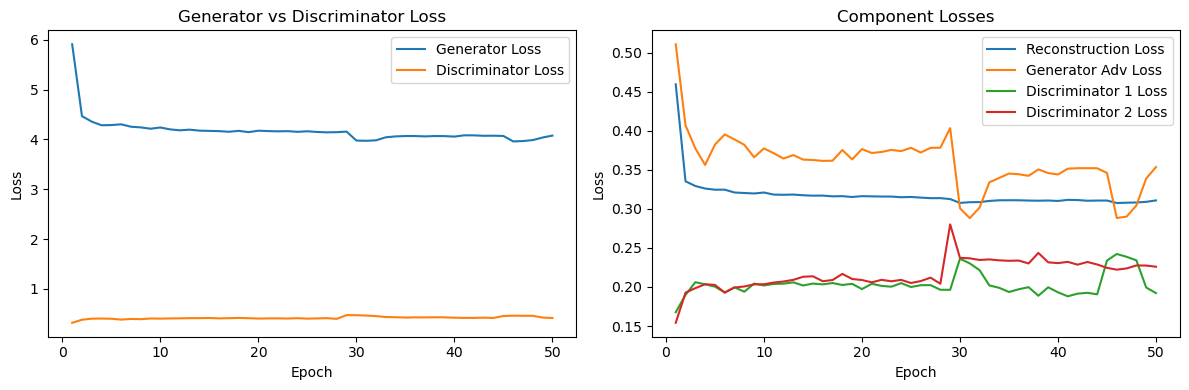

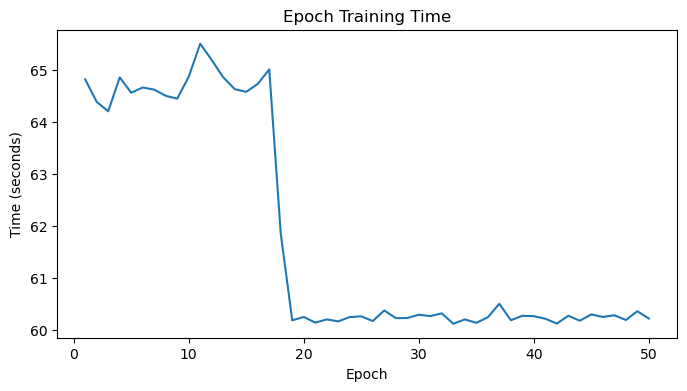

Model saved at epoch 50
Training completed successfully!
Model checkpoints saved in: checkpoints/intermediate/ddcgan_fusion
Final model saved in: checkpoints/final/ddcgan_fusion
Sample images saved in: results/ddcgan_fusion/samples
Training plots saved in: results/ddcgan_fusion/plots


In [6]:
print("Starting model training...")

# Only run if dataset is available
if DATASET_PATH and os.path.exists(DATASET_PATH):
    try:
        # Create trainer
        trainer = DDcGANTrainer(
            dataset_path=DATASET_PATH,
            batch_size=BATCH_SIZE,
            lr=LEARNING_RATE,
            img_size=IMG_SIZE,
            device=DEVICE
        )
        
        print("Trainer created successfully. Starting training...")
        
        # Start training
        trainer.train(NUM_EPOCHS, save_interval=10)
        
        # Save final model
        trainer.save_model(NUM_EPOCHS, FINAL_MODELS_DIR)
        
        print("Training completed successfully!")
        print(f"Model checkpoints saved in: {CHECKPOINTS_DIR}")
        print(f"Final model saved in: {FINAL_MODELS_DIR}")
        print(f"Sample images saved in: {SAMPLES_DIR}")
        print(f"Training plots saved in: {PLOTS_DIR}")
        
    except Exception as e:
        print(f"Error during training: {e}")
        print("Training failed. Please check the dataset path and format.")
        import traceback
        traceback.print_exc()
else:
    print("Dataset not available. Please ensure the KAIST dataset is properly set up.")
    

Setting up demonstration and testing...
Found checkpoint: checkpoints/intermediate/ddcgan_fusion/ddcgan_epoch_50.pth
✓ Loaded model from checkpoints/intermediate/ddcgan_fusion/ddcgan_epoch_50.pth
Scanning dataset directory: ../Dataset/train
Found CT and MRI directories
Found 3208 CT images and 3208 MRI images
Found 3208 valid image pairs


/tmp/ipykernel_26792/1535192342.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=DEVICE)


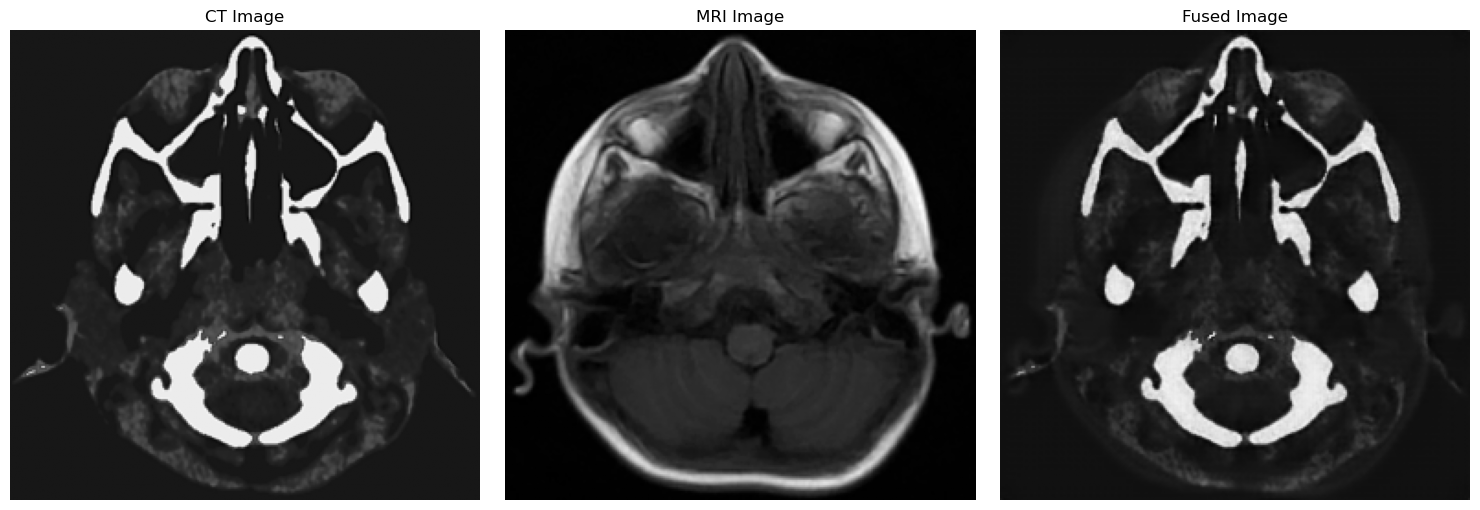

Demonstration completed! Image saved as 'results/ddcgan_fusion/test_demonstration.png'
Demonstration and testing complete!


In [7]:
print("Setting up demonstration and testing...")

def load_test_image_pair():
    """Load a sample CT and MRI image pair for testing"""
    # Create a simple test dataset
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
    
    try:
        test_dataset = CTMRIDataset(DATASET_PATH, transform=test_transform, img_size=IMG_SIZE)
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
        
        # Get one sample
        for ct_img, mri_img in test_loader:
            return ct_img, mri_img
    except:
        # Create dummy data if dataset is not available
        print("Using dummy data for demonstration")
        dummy_ct = torch.rand(1, 1, IMG_SIZE[0], IMG_SIZE[1]) * 2 - 1
        dummy_mri = torch.rand(1, 1, IMG_SIZE[0], IMG_SIZE[1]) * 2 - 1
        return dummy_ct, dummy_mri

def test_model(checkpoint_path=None):
    """Test the trained model on sample images"""
    # Create a simple generator for demonstration if no checkpoint is available
    generator = Generator(in_channels=2, out_channels=1).to(DEVICE)
    
    if checkpoint_path and os.path.exists(checkpoint_path):
        try:
            # Load checkpoint
            checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
            generator.load_state_dict(checkpoint['generator_state_dict'])
            print(f"✓ Loaded model from {checkpoint_path}")
        except Exception as e:
            print(f"✗ Could not load model: {e}")
            print("Using untrained model for demonstration")
    else:
        print("No checkpoint provided. Using untrained model for demonstration.")
    
    # Set to evaluation mode
    generator.eval()
    
    # Load test images
    ct_img, mri_img = load_test_image_pair()
    ct_img = ct_img.to(DEVICE)
    mri_img = mri_img.to(DEVICE)
    
    # Create input by concatenating CT and MRI images
    input_img = torch.cat([ct_img, mri_img], dim=1)
    
    # Generate fused image
    with torch.no_grad():
        fused_img = generator(input_img)
    
    # Denormalize images for display
    ct_img_display = (ct_img.cpu().squeeze() + 1) / 2
    mri_img_display = (mri_img.cpu().squeeze() + 1) / 2
    fused_img_display = (fused_img.cpu().squeeze() + 1) / 2
    
    # Create comparison plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(ct_img_display, cmap='gray')
    axes[0].set_title('CT Image')
    axes[0].axis('off')
    
    axes[1].imshow(mri_img_display, cmap='gray')
    axes[1].set_title('MRI Image')
    axes[1].axis('off')
    
    axes[2].imshow(fused_img_display, cmap='gray')
    axes[2].set_title('Fused Image')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.savefig(f'{RESULTS_DIR}/test_demonstration.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Demonstration completed! Image saved as '{RESULTS_DIR}/test_demonstration.png'")

# Check for available checkpoints
checkpoint_files = []
if os.path.exists(CHECKPOINTS_DIR):
    checkpoint_files = [f for f in os.listdir(CHECKPOINTS_DIR) if f.endswith('.pth')]
if os.path.exists(FINAL_MODELS_DIR):
    checkpoint_files.extend([f for f in os.listdir(FINAL_MODELS_DIR) if f.endswith('.pth')])

if checkpoint_files:
    # Use the latest checkpoint
    checkpoint_files.sort()
    latest_checkpoint = os.path.join(CHECKPOINTS_DIR if checkpoint_files[-1] in os.listdir(CHECKPOINTS_DIR) else FINAL_MODELS_DIR, 
                                    checkpoint_files[-1])
    print(f"Found checkpoint: {latest_checkpoint}")
    test_model(latest_checkpoint)
else:
    print("No checkpoints found. Running demonstration with untrained model.")
    test_model()

print("Demonstration and testing complete!")